# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

Run this script changing for prefix and the filtering step subset for :
- tumor_male, only tumor and male 
- tumor_female, only tumor and female
- normal_male, only normal and male
- normal_female, only normal and female 
- only tumor 
- only normal

In [1]:
prefix="tumor_male"

In [2]:
import warnings

import matplotlib

# import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# import altair as alt
# import pertpy as pt
# from pandas.api.types import is_categorical_dtype
# from pandas import CategoricalDtype

In [3]:
import decoupler as dc

In [4]:
from typing_extensions import Buffer

In [5]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"

In [6]:
subset_adata = sc.read_h5ad(f"{path}/out/007_re_analysis/tables/subset_adata.h5ad")

In [7]:
subset_adata.raw.var.index = subset_adata.raw.var.feature_name

In [8]:
subset_adata.var.index = subset_adata.var.feature_name

In [9]:
subset_adata

AnnData object with n_obs × n_vars = 638804 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

## Subset only for normal male

In [10]:
subset_adata = subset_adata[subset_adata.obs["origin"] == "tumor_primary"]

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
subset_adata = subset_adata[subset_adata.obs["sex"] == "male"]

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
subset_adata.obs.origin.value_counts()

tumor_primary    259402
Name: origin, dtype: int64

In [13]:
subset_adata.obs.sex.value_counts()

male    259402
Name: sex, dtype: int64

## SC Pathway activity inference

In [14]:
progeny = dc.get_progeny(organism="human", top=500)

In [15]:
subset_adata.var["gene_id"] = subset_adata.var.index

/tmp/ipykernel_1712487/1371716265.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  subset_adata.var["gene_id"] = subset_adata.var.index
/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
subset_adata.var.set_index("feature_name", inplace=True)

In [17]:
subset_adata.var.index.rename("index",inplace = True)

In [18]:
subset_adata.raw.var.index = subset_adata.raw.var.feature_name

In [19]:
dc.run_mlm(
    mat=subset_adata,
    net=progeny,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
)

Running mlm on mat with 259402 samples and 17811 targets for 14 sources.


100%|██████████| 26/26 [03:44<00:00,  8.63s/it]


In [20]:
subset_adata.obsm["mlm_estimate"]

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACCCAAGAGCCATG-1_0-1,-0.491594,0.057151,0.121406,0.598365,0.989726,-0.491019,1.772198,-0.750225,-0.283499,-0.258706,-0.996463,-0.434491,-0.121263,-0.652269
AAACCCAAGATTAGAC-1_0-1,0.643365,0.641756,-0.290453,0.202765,0.663411,-0.400839,-0.464452,0.425819,-0.900883,0.297172,-1.571066,0.053900,-0.058456,-0.225732
AAACCCAAGGTCGCCT-1_0-1,-0.254079,0.423200,-0.404513,0.368914,0.933463,-0.547602,-0.683023,-0.093123,-0.584421,0.755512,-0.073128,0.020253,0.054664,-0.371049
AAACCCAAGTCATTGC-1_0-1,0.184239,1.152927,-0.275863,0.015234,0.731056,-1.013506,-0.589087,-2.644645,-0.367562,0.976734,0.065790,-1.036229,-0.136624,-0.653843
AAACCCACACTCCTTG-1_0-1,-0.170938,0.959639,-0.763232,1.190994,0.220922,-0.296641,1.527747,-1.420762,-0.585409,-0.550638,-0.825923,-0.601435,0.146632,0.570653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCGTCCGAAGA-1-34-8,0.744310,2.201368,0.206307,2.073007,1.686348,-1.493915,0.994755,-0.432389,-0.611580,1.190804,-0.181343,-0.400612,0.276593,-0.318240
TTTGCGCGTCTGATTG-1-34-8,-0.524320,0.744794,-0.049426,0.694616,0.247992,-0.929716,-0.477438,-0.177628,-0.802223,0.655394,0.215338,-0.387402,0.349972,-0.068010
TTTGCGCTCGAGAACG-1-34-8,-0.111065,0.371361,-0.099319,0.947448,0.400108,-0.670597,-0.594307,-0.282933,-0.045247,1.063888,0.021638,-0.194387,0.050192,-0.158469
TTTGCGCTCTGGCGAC-1-34-8,-0.027724,1.352867,-0.307925,1.163482,0.852988,-0.955113,-0.545830,-0.030168,-0.847762,1.175325,0.166688,-0.676542,0.538162,-0.548050


In [21]:
subset_adata.obsm["progeny_mlm_estimate"] = subset_adata.obsm["mlm_estimate"].copy()
subset_adata.obsm["progeny_mlm_pvals"] = subset_adata.obsm["mlm_pvals"].copy()
subset_adata

AnnData object with n_obs × n_vars = 259402 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [22]:
acts = dc.get_acts(subset_adata, obsm_key="mlm_estimate")
acts

AnnData object with n_obs × n_vars = 259402 × 14
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    uns: '_scvi', 'ann_fine_colors', 'batch_condition', 'cell_

In [23]:
#acts.obsm["mlm_estimate"]

In [24]:
# Visualization
#sc.pl.umap(acts, color=["Androgen", "cell_type"], cmap="RdBu_r", vcenter=0)
#sc.pl.violin(acts, keys=["Androgen"], groupby="cell_type", rotation=90)

In [25]:
# Visualization
#sc.pl.umap(acts, color=["Estrogen", "cell_type"], cmap="RdBu_r", vcenter=0)
#sc.pl.violin(acts, keys=["Estrogen"], groupby="cell_type", rotation=90)

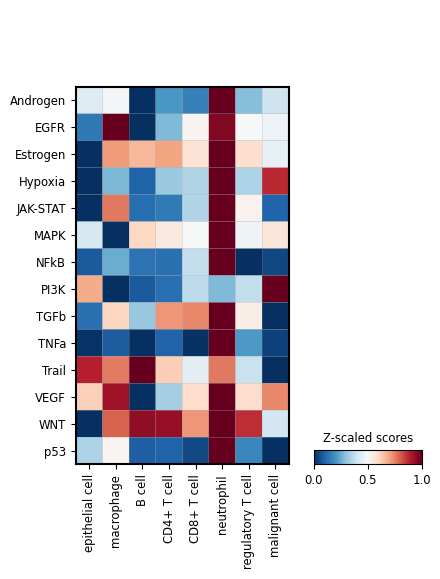

In [26]:
# Exploration
sc.pl.matrixplot(
    acts,
    var_names=acts.var_names,
    groupby="cell_type",
    dendrogram=False,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
    swap_axes=True,
    save=f"sc_pathway_{prefix}.png",
)

In [27]:
# Specific genes
#sc.pl.violin(acts, keys=["Androgen"], groupby="cell_type", rotation=90)

## SC Transcription factor activity inference

In [28]:
net = dc.get_collectri(organism="human", split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [29]:
dc.run_ulm(
    mat=subset_adata,
    net=net,
    source="source",
    target="target",
    weight="weight",
    verbose=True,
)


Running ulm on mat with 259402 samples and 17811 targets for 738 sources.


100%|██████████| 26/26 [01:42<00:00,  3.96s/it]


In [30]:
subset_adata.obsm["ulm_estimate"]

,ABL1,AEBP1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,...,ZNF384,ZNF395,ZNF410,ZNF423,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
AAACCCAAGAGCCATG-1_0-1,0.869942,-0.143168,-0.190176,-0.047719,0.174268,0.268042,1.988538,-0.123545,0.504966,-0.282351,...,-0.435771,-0.282371,-0.143167,-0.238637,-0.282367,-0.495190,-0.761817,2.009845,2.988480,2.508286
AAACCCAAGATTAGAC-1_0-1,-0.232329,-0.164265,-0.136988,-0.054750,0.115413,0.140151,0.612715,0.263465,0.901854,-0.010898,...,-0.415433,-0.245710,-0.071667,-0.273801,-0.167438,-0.131160,-0.060568,-0.089393,5.533345,-0.215422
AAACCCAAGGTCGCCT-1_0-1,1.462684,-0.102386,-0.064699,-0.034126,0.124627,0.293918,1.352671,0.454002,1.173064,-0.201922,...,-0.311640,-0.201936,-0.102386,-0.170660,-0.201934,-0.109647,-0.086529,-0.096530,0.875621,1.888616
AAACCCAAGTCATTGC-1_0-1,3.514848,0.173438,0.326874,-0.044887,0.163926,0.012648,1.149771,0.255960,1.818010,-0.265596,...,-0.269238,-0.265614,-0.134671,-0.224475,-0.005177,-0.198469,0.146577,-0.780575,0.874685,2.567810
AAACCCACACTCCTTG-1_0-1,5.650803,-0.163625,2.015935,-0.054537,0.199168,1.241402,3.627181,-0.431421,1.759542,0.067548,...,-0.498039,-0.322719,-0.163625,-0.272735,-0.322715,0.198398,-0.138284,-0.154266,1.007428,1.387564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCGTCCGAAGA-1-34-8,0.257358,3.999560,1.829057,-0.048365,-0.022431,5.262171,4.020806,3.545253,5.099477,-0.286175,...,-0.441673,-0.286194,-0.145106,-0.241867,-0.286191,-0.045642,0.245920,-0.136806,0.398039,0.332287
TTTGCGCGTCTGATTG-1-34-8,0.166100,-0.117163,-0.490378,-0.039051,0.142613,-0.036855,0.212168,0.631283,1.333340,-0.231065,...,-0.249505,-0.231081,-0.117163,-0.195290,-0.032778,-0.454138,-0.099018,0.055426,0.040650,-0.213955
TTTGCGCTCGAGAACG-1-34-8,0.060906,0.154658,-0.180183,-0.022842,0.083419,0.101436,0.043008,0.240640,0.600687,-0.135156,...,-0.208595,0.242148,-0.068532,-0.114231,-0.135164,-0.354323,0.319330,-0.222429,0.610024,0.690011
TTTGCGCTCTGGCGAC-1-34-8,-0.141484,-0.100035,-0.384927,-0.474223,0.121765,0.312786,0.808398,1.746452,2.161578,0.175378,...,-0.304482,-0.197300,-0.100034,-0.166740,-0.197298,-0.232247,-0.084542,-0.717862,1.061010,1.025108


In [31]:
subset_adata.obsm["collectri_ulm_estimate"] = subset_adata.obsm["ulm_estimate"].copy()
subset_adata.obsm["collectri_ulm_pvals"] = subset_adata.obsm["ulm_pvals"].copy()
subset_adata

AnnData object with n_obs × n_vars = 259402 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [32]:
acts = dc.get_acts(subset_adata, obsm_key="ulm_estimate")
acts

AnnData object with n_obs × n_vars = 259402 × 738
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    uns: '_scvi', 'ann_fine_colors', 'batch_condition', 'cell

In [33]:
# Specific TF
#sc.pl.umap(acts, color=["SREBF1", "cell_type"], cmap="RdBu_r", vcenter=0)
#sc.pl.violin(acts, keys=["SREBF1"], groupby="cell_type", rotation=90)

In [34]:
#sc.pl.umap(subset_adata, color=["YY1", "cell_type"])
#sc.pl.violin(subset_adata, keys=["YY1"], groupby="cell_type", rotation=90)

In [35]:
# Exploration
df = dc.rank_sources_groups(
    acts, groupby="cell_type", reference="rest", method="t-test_overestim_var"
)
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cell,rest,EBF1,180.034212,0.557067,0.0,0.0
1,B cell,rest,PHF5A,161.448116,0.757716,0.0,0.0
2,B cell,rest,NOTO,115.960013,2.831476,0.0,0.0
3,B cell,rest,MBD2,112.783100,1.092998,0.0,0.0
4,B cell,rest,TFDP1,109.657073,1.556231,0.0,0.0
...,...,...,...,...,...,...,...
5899,regulatory T cell,rest,DNMT1,-65.331045,-0.507883,0.0,0.0
5900,regulatory T cell,rest,TEAD1,-66.487489,-0.630323,0.0,0.0
5901,regulatory T cell,rest,IRF8,-69.391775,-0.740427,0.0,0.0
5902,regulatory T cell,rest,DNMT3B,-71.340883,-0.540224,0.0,0.0


In [36]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .groupby("group")["names"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'B cell': ['EBF1', 'PHF5A', 'NOTO'],
 'CD4+ T cell': ['ZBED1', 'ZBTB4', 'GBX2'],
 'CD8+ T cell': ['KLF13', 'NFKB2', 'IRF7'],
 'epithelial cell': ['NKX2-1', 'RXRG', 'FOXF2'],
 'macrophage': ['NR1H3', 'SP3', 'PITX3'],
 'malignant cell': ['NFE2L2', 'TBPL1', 'SALL4'],
 'neutrophil': ['CEBPB', 'JUN', 'PPARD'],
 'regulatory T cell': ['NFKB2', 'ZFX', 'FOXP3']}

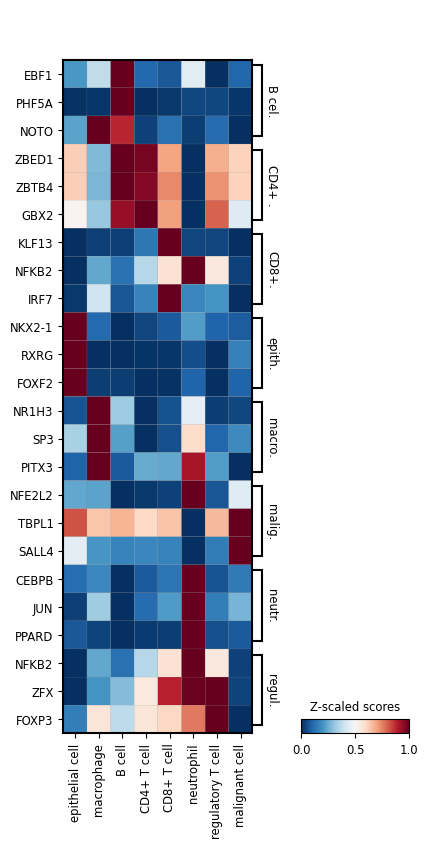

In [37]:
sc.pl.matrixplot(
    acts,
    source_markers,
    "cell_type",
    dendrogram=False,
    standard_scale="var",
    colorbar_title="Z-scaled scores",
    cmap="RdBu_r",
    swap_axes=True,
     save=f"sc_transcription_factor_{prefix}.png",
)

In [38]:
# Specific TF
#sc.pl.violin(acts, keys=["SPIB"], groupby="cell_type", rotation=90)

## SC SigDB gene sets

In [39]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MSC,oncogenic_signatures,PKCA_DN.V1_DN
1,MSC,mirna_targets,MIR12123
2,MSC,chemical_and_genetic_perturbations,NIKOLSKY_BREAST_CANCER_8Q12_Q22_AMPLICON
3,MSC,immunologic_signatures,GSE32986_UNSTIM_VS_GMCSF_AND_CURDLAN_LOWDOSE_S...
4,MSC,chemical_and_genetic_perturbations,BENPORATH_PRC2_TARGETS
...,...,...,...
2407729,OR2W5P,immunologic_signatures,GSE22601_DOUBLE_NEGATIVE_VS_CD8_SINGLE_POSITIV...
2407730,OR2W5P,immunologic_signatures,KANNAN_BLOOD_2012_2013_TIV_AGE_65PLS_REVACCINA...
2407731,OR52L2P,immunologic_signatures,GSE22342_CD11C_HIGH_VS_LOW_DECIDUAL_MACROPHAGE...
2407732,CSNK2A3,immunologic_signatures,OCONNOR_PBMC_MENVEO_ACWYVAX_AGE_30_70YO_7DY_AF...


In [40]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

,genesymbol,collection,geneset
11,MSC,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
149,ICOSLG,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
223,ICOSLG,hallmark,HALLMARK_INFLAMMATORY_RESPONSE
270,ICOSLG,hallmark,HALLMARK_ALLOGRAFT_REJECTION
398,FOSL2,hallmark,HALLMARK_HYPOXIA
...,...,...,...
878342,FOXO1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878418,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878512,PDX1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878605,INS,hallmark,HALLMARK_PANCREAS_BETA_CELLS


In [41]:
dc.run_ora(
    mat=subset_adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True
)

Running ora on mat with 259402 samples and 17811 targets for 50 sources.


100%|██████████| 259402/259402 [38:59<00:00, 110.86it/s]


In [42]:
subset_adata.obsm['ora_estimate']

source,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_HYPOXIA,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_COAGULATION,HALLMARK_P53_PATHWAY,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_UV_RESPONSE_UP,HALLMARK_IL6_JAK_STAT3_SIGNALING,...,HALLMARK_HEDGEHOG_SIGNALING,HALLMARK_GLYCOLYSIS,HALLMARK_DNA_REPAIR,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_APICAL_SURFACE,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_HEME_METABOLISM,HALLMARK_SPERMATOGENESIS,HALLMARK_PANCREAS_BETA_CELLS,HALLMARK_OXIDATIVE_PHOSPHORYLATION
AAACCCAAGAGCCATG-1_0-1,1.463802,1.480218,11.120653,2.188393,1.001787,0.163523,3.642362,8.880812,0.798846,1.073040,...,-0.000000,0.179880,3.417419,0.452499,0.069145,2.179716,0.011093,0.062879,0.158357,7.153353
AAACCCAAGATTAGAC-1_0-1,0.738158,0.009117,1.267177,1.267177,1.530495,1.203815,1.778759,3.612347,1.048966,0.277518,...,-0.000000,3.250860,0.875740,0.178394,-0.000000,2.643304,2.232238,0.062879,0.969217,26.047981
AAACCCAAGGTCGCCT-1_0-1,1.194127,1.208422,7.345171,3.336049,0.587366,0.008491,5.531508,4.511173,0.798846,1.450006,...,-0.000000,0.976602,0.645624,0.452499,0.069145,1.372306,0.445772,0.019354,0.969217,5.531508
AAACCCAAGTCATTGC-1_0-1,6.011438,0.748410,9.796189,1.854979,0.587366,0.031157,5.028793,4.991599,5.216590,0.277518,...,0.093436,0.976602,0.645624,1.141798,0.248753,2.643304,0.445772,0.019354,0.490057,5.531508
AAACCCACACTCCTTG-1_0-1,11.476524,1.480218,3.764982,3.764982,0.587366,0.287267,4.083592,6.549745,5.775545,0.749677,...,-0.000000,0.976602,0.875740,1.776429,-0.000000,3.143951,0.812638,0.003133,0.969217,8.324364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCGTCCGAAGA-1-34-8,17.378181,5.028793,11.806371,6.775996,2.903508,3.200446,7.153353,9.505876,6.356775,1.073040,...,0.093436,6.095937,1.442494,4.404043,-0.000000,5.482014,0.118301,0.019354,0.490057,19.081839
TTTGCGCGTCTGATTG-1-34-8,2.082357,0.964225,4.687913,2.546948,0.424512,0.031157,5.028793,1.760169,1.048966,0.483488,...,0.317946,1.797533,4.404043,2.142204,0.248753,5.482014,0.198859,-0.000000,1.572178,15.900500
TTTGCGCTCGAGAACG-1-34-8,3.612347,0.275975,5.180562,6.775996,1.835641,0.287267,6.053525,2.429496,2.376859,0.277518,...,0.093436,1.797533,2.538467,2.142204,0.248753,1.372306,0.198859,0.003133,-0.000000,3.642362
TTTGCGCTCTGGCGAC-1-34-8,3.195282,0.748410,6.775996,2.929776,1.001787,0.287267,2.452558,4.511173,1.048966,1.073040,...,0.093436,0.105708,2.142204,1.141798,0.541237,1.033262,0.029148,0.003133,0.158357,7.730187


In [43]:
#Visualization
acts = dc.get_acts(subset_adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

/home/kvalem/.conda/envs/nsclc_gender_atlas_23/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 259402 × 50
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    uns: '_scvi', 'ann_fine_colors', 'batch_condition', 'cell_

In [44]:
#sc.pl.umap(acts, color=['HALLMARK_ESTROGEN_RESPONSE_LATE', 'cell_type'], cmap='RdBu_r')
#sc.pl.violin(acts, keys=['HALLMARK_ESTROGEN_RESPONSE_LATE'], groupby='cell_type', rotation=90)

In [45]:
#Exploration
df = dc.rank_sources_groups(acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cell,rest,HALLMARK_KRAS_SIGNALING_DN,20.827477,0.021326,6.589936e-96,8.905319e-96
1,B cell,rest,HALLMARK_ALLOGRAFT_REJECTION,16.259751,0.512614,3.030921e-59,3.524327e-59
2,B cell,rest,HALLMARK_MYC_TARGETS_V2,9.987402,0.088561,1.827437e-23,1.986344e-23
3,B cell,rest,HALLMARK_INTERFERON_GAMMA_RESPONSE,-0.434599,-0.014431,6.638562e-01,6.638562e-01
4,B cell,rest,HALLMARK_MYC_TARGETS_V1,-4.804185,-0.396708,1.559168e-06,1.590988e-06
...,...,...,...,...,...,...,...
395,regulatory T cell,rest,HALLMARK_ESTROGEN_RESPONSE_EARLY,-59.182854,-0.488981,0.000000e+00,0.000000e+00
396,regulatory T cell,rest,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,-59.611203,-0.677603,0.000000e+00,0.000000e+00
397,regulatory T cell,rest,HALLMARK_XENOBIOTIC_METABOLISM,-60.338863,-0.555175,0.000000e+00,0.000000e+00
398,regulatory T cell,rest,HALLMARK_CHOLESTEROL_HOMEOSTASIS,-60.436051,-0.719219,0.000000e+00,0.000000e+00


In [46]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'B cell': ['HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_MYC_TARGETS_V2'],
 'CD4+ T cell': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_WNT_BETA_CATENIN_SIGNALING'],
 'CD8+ T cell': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE',
  'HALLMARK_PI3K_AKT_MTOR_SIGNALING'],
 'epithelial cell': ['HALLMARK_ESTROGEN_RESPONSE_EARLY',
  'HALLMARK_ESTROGEN_RESPONSE_LATE',
  'HALLMARK_NOTCH_SIGNALING'],
 'macrophage': ['HALLMARK_COMPLEMENT',
  'HALLMARK_COAGULATION',
  'HALLMARK_KRAS_SIGNALING_UP'],
 'malignant cell': ['HALLMARK_GLYCOLYSIS',
  'HALLMARK_ESTROGEN_RESPONSE_LATE',
  'HALLMARK_ESTROGEN_RESPONSE_EARLY'],
 'neutrophil': ['HALLMARK_TNFA_SIGNALING_VIA_NFKB',
  'HALLMARK_INFLAMMATORY_RESPONSE',
  'HALLMARK_IL6_JAK_STAT3_SIGNALING'],
 'regulatory T cell': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_IL2_STAT5_SIGNALING',
  'HALLMARK_PI3K_AKT_MTOR_SIGNALING']}

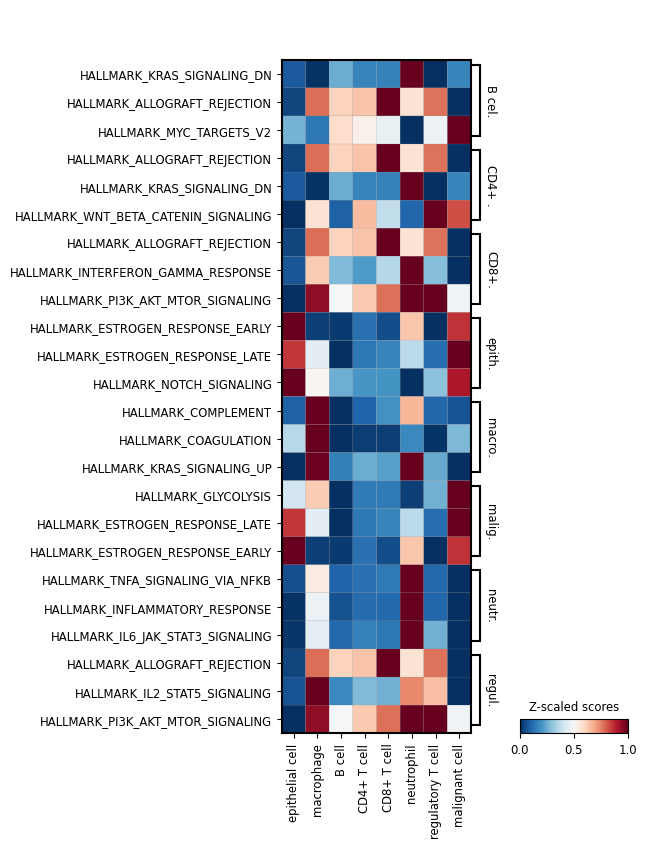

In [47]:
sc.pl.matrixplot(acts, source_markers, 'cell_type', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', swap_axes=True,     save=f"sc_biological_process_{prefix}.png",)

In [48]:
subset_adata.write_h5ad(f"{path}/out/007_re_analysis/tables/subset_adata_estimates_{prefix}.h5ad")
#subset_adata = sc.read_h5ad(f"{path}/out/007_re_analysis/tables/input/subset_adata_estimates_tumor_and_normal.h5ad")

In [49]:
subset_adata.obs.origin.value_counts()

tumor_primary    259402
Name: origin, dtype: int64

In [50]:
subset_adata.obs.sex.value_counts()

male    259402
Name: sex, dtype: int64